# Correlation


* Import GBP/USD.csv, fuel_prices_com.csv & owid_covid_data.csv

* Definition:  Stepwise regression is a method of fitting regression models in which the choice of independent variables is carried out by an automatic procedure.
Correlation of Features

* We shall do this by carrying out three processes:
1. Correlation 
2. Variance Inflation Factor
3. Backward elimination

Data was filtered down to extract the feature that had the most effect on our prediction. This was carried out by looking at the bivariate correlation of features & carrying out a process called backward elimination.

Correlation Steps:

1.   A list of indepedent and dependent variables were generated. Independent = total_cases, total_deaths & fuel_price. Dependent = forex_price.
2.  The relationships between each independent variable and the dependent variable were checked using correlations.
3. The relationships among the independent variables were checked using correlations.
4.  Non-redundant independent variables were used in the analysis to find the best fitting model.
5. The best fitting model was used to make predictions about the dependent variable.







# Imports

In [ ]:
# Libraries
import pathlib
import numpy as np
import pandas as pd
# Graphs
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
# Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
# Checking for multicolinearity
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import linregress
# Modeling metrics
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt



# Data Collection


In [ ]:
# Importing covid_dataset using pandas. 
covid_dataset_data= pd.read_csv('owid_covid_data.csv', na_values = "?", comment='\t', skipinitialspace=True)
covid_dataset = covid_dataset_data.copy()
covid_dataset = covid_dataset.loc[covid_dataset.location=='United States', ['date', 'total_cases', 'total_deaths']]
covid_dataset.head()
# covid_dataset = covid_dataset.dropna()  
# We do not want to drop empty tables as this is null values are part of our dataset


,date,total_cases,total_deaths
32403,2019-12-31,0.0,0.0
32404,2020-01-01,0.0,0.0
32405,2020-01-02,0.0,0.0
32406,2020-01-03,0.0,0.0
32407,2020-01-04,0.0,0.0


In [ ]:
# Import forex
forex_dataset_data= pd.read_csv('GBP_USD.csv', na_values = "?", comment='\t', skipinitialspace=True)
forex_dataset = forex_dataset_data.copy()
forex_dataset = forex_dataset.fillna(method='ffill')
forex_dataset = pd.DataFrame(forex_dataset,columns=['Price','Date'])


In [ ]:
# Import fuel price
fuel_dataset = pd.read_csv('fuel_prices_com.csv', encoding= 'unicode_escape')
fuel_dataset = fuel_dataset.loc[fuel_dataset.Country=='USA', ['Date','Diesel', 'Brent oil price']]

In [ ]:
print(covid_dataset.shape), print(forex_dataset.shape),print(fuel_dataset.shape)

(218, 3)
(214, 2)
(29, 3)


(None, None, None)

# Data Preprocessing / Data Cleaning & Collating


*   We first isolate the date column both fuel_dataset and forex_dataset so that they are formatted in the same way.  
*   Challenge: Fuel Price dataset is a weekly timeseries dataset whereas Forex Price is a daily timeseries dataset.




In [ ]:
# We first convert the value to a string datetime 
fuel_dataset['Date'] = fuel_dataset['Date'].apply(lambda x: pd.to_datetime(str(x)))
fuel_dataset['Date'].head()


772   2020-06-01
773   2020-01-13
774   2020-01-20
775   2020-01-27
776   2020-03-02
Name: Date, dtype: datetime64[ns]

In [ ]:
# We find out the format for where the day, month and year lie.
fuel_dataset["Date"] = pd.to_datetime(fuel_dataset["Date"], format="%d-%m-%Y")
forex_dataset["Date"] = pd.to_datetime(forex_dataset["Date"], format="%b %d, %Y")
# We transform these values to the same format.
fuel_dataset["Date"] = fuel_dataset["Date"].dt.strftime("%d-%m-%Y")
forex_dataset["Date"] = forex_dataset["Date"].dt.strftime("%d-%m-%Y")
# We then convert them back to a dataframe.
fuel_dataset["Date"] = pd.to_datetime(fuel_dataset["Date"], format="%d-%m-%Y")
forex_dataset["Date"] = pd.to_datetime(forex_dataset["Date"], format="%d-%m-%Y")

In [ ]:
# We set the index for both datasets to be date.
forex_dataset.set_index("Date", inplace=True)
fuel_dataset.set_index("Date", inplace=True)
forex_dataset["Date"] = forex_dataset.index
fuel_dataset["date"] = fuel_dataset.index

In [ ]:
# We then group these dates in a weekly period column
fuel_dataset["week"] = fuel_dataset.index.to_period('W')
forex_dataset["week"] = forex_dataset.index.to_period('W')

In [ ]:
# We then join our datasets on the week column
data_ff = pd.merge(
    forex_dataset,
    fuel_dataset,
    left_on="week",
    right_on="week",
    how="left"
)

In [ ]:
data_ff[data_ff.Diesel.isnull() | data_ff.Price.isnull()]
data_ff['Brent oil price'].isnull()

0      True
1      True
2      True
3      True
4      True
       ... 
230    True
231    True
232    True
233    True
234    True
Name: Brent oil price, Length: 235, dtype: bool

In [ ]:
# We isolate the features that we want in our dataset
data_ff = pd.DataFrame(data_ff, columns = ['Date', 'Price', 'Diesel', 'Brent oil price']) 
# In order to merge with the next dataset we have to convert our Date frome from a datatime type to a string object.
data_ff['Date'] = data_ff['Date'].astype(str)

In [ ]:
# We merge covid dataset with the forex + fuel dataset
data_ff = pd.merge(left=data_ff, left_on='Date',
         right=covid_dataset, right_on='date')

In [ ]:
# Fill diesel with the mean 
data_ff = pd.DataFrame(data_ff, columns = ['Date', 'Price','total_deaths', 'total_cases','Diesel', 'Brent oil price']) 
data_ff['Diesel'].fillna((data_ff['Diesel'].mean()), inplace=True) # Notice how our dataset starts from the end rather than the top
data_ff['Brent oil price'].fillna((data_ff['Brent oil price'].mean()), inplace=True)
dataset = data_ff.iloc[::-1,:] # Reverse order of dataset
dataset.reset_index(drop=True, inplace=True) #Reset index

In [ ]:
dataset = pd.DataFrame(dataset, columns = ['Date', 'Price', 'total_cases', 'total_deaths','Diesel', 'Brent oil price']) 
dataset

,Date,Price,total_cases,total_deaths,Diesel,Brent oil price
0,2019-12-31,1.3261,0.0,0.0,0.69532,42.1508
1,2020-01-01,1.3255,0.0,0.0,0.69532,42.1508
2,2020-01-02,1.3146,0.0,0.0,0.69532,42.1508
3,2020-01-03,1.3088,0.0,0.0,0.69532,42.1508
4,2020-01-04,1.3169,0.0,0.0,0.69532,42.1508
...,...,...,...,...,...,...
230,2020-07-27,1.2882,4234020.0,146935.0,0.69532,42.1508
231,2020-07-28,1.2932,4290263.0,148011.0,0.69532,42.1508
232,2020-07-29,1.2996,4351997.0,149256.0,0.69532,42.1508
233,2020-07-30,1.3095,4426982.0,150713.0,0.69532,42.1508


# Plotting Features before Normalisation

### Organising date for plotting

In [ ]:
# Isolate date for plotting
date = dataset['Date']
dateFormatting = pd.DataFrame({'new_date': pd.date_range('2019-12-31', '2020-07-31', periods=len(date))})
# Convert date to list so that we can use the dates to plot on graph
my_xticks = dateFormatting['new_date'].tolist()

### Plotting Forex Spot Price

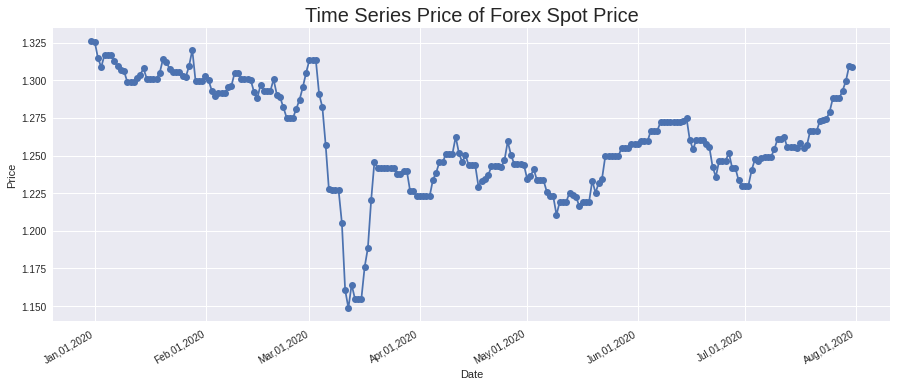

In [ ]:
rcParams['figure.figsize'] = 15,6
dates = np.array(dateFormatting['new_date'])
price = np.array(dataset['Price'])
plt.plot_date(dates,price, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series Price of Forex Spot Price', size = 20)
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(date_format)

### Plotting Diesel Prices

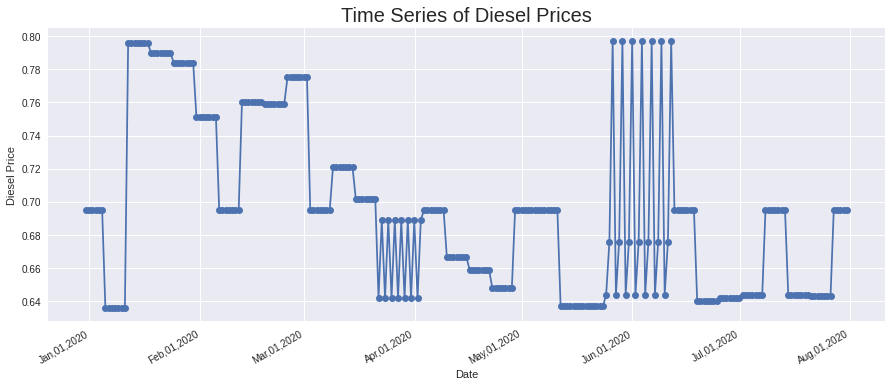

In [ ]:
rcParams['figure.figsize'] = 15,6
dates = np.array(dateFormatting['new_date'])
diesel = np.array(dataset['Diesel'])
plt.plot_date(dates,diesel, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Diesel Prices', size = 20)
plt.xlabel('Date')
plt.ylabel('Diesel Price')
plt.gca().xaxis.set_major_formatter(date_format)

# Plotting Brent Oil Prices

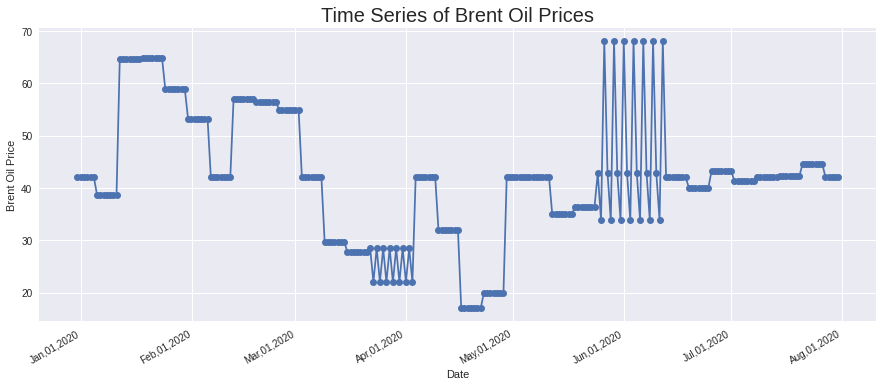

In [ ]:
rcParams['figure.figsize'] = 15,6
dates = np.array(dateFormatting['new_date'])
brent_oil = np.array(dataset['Brent oil price'])
plt.plot_date(dates,brent_oil, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Brent Oil Prices', size = 20)
plt.xlabel('Date')
plt.ylabel('Brent Oil Price')
plt.gca().xaxis.set_major_formatter(date_format)

### Plotting Accumulative Covid Deaths

In [ ]:
# Adds the accumulative deaths every day of a country
total_deaths = dataset['total_deaths']
newDayDeaths = 0
daily_total_deaths = []
for dailyDeaths in total_deaths:
  newDayDeaths = dailyDeaths + newDayDeaths
  daily_total_deaths.append(newDayDeaths)


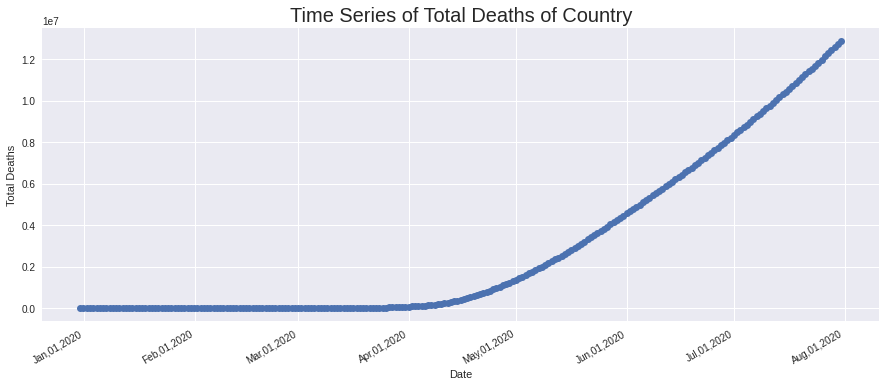

In [ ]:
# Plots the accumulative daily death rates of a country
dates = np.array(dateFormatting['new_date'])
deaths = np.array(daily_total_deaths)
plt.plot_date(dates, deaths, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Deaths of Country', size = 20)
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.gca().xaxis.set_major_formatter(date_format)



### Plotting Accumulative Positive Cases

In [ ]:
# Adds accumulative confirmed cases of a country
total_cases = dataset['total_cases']
newDayCases = 0
daily_total_cases = []
for dailyCases in total_cases:
  newDayCases = dailyCases + newDayCases
  daily_total_cases.append(newDayCases)

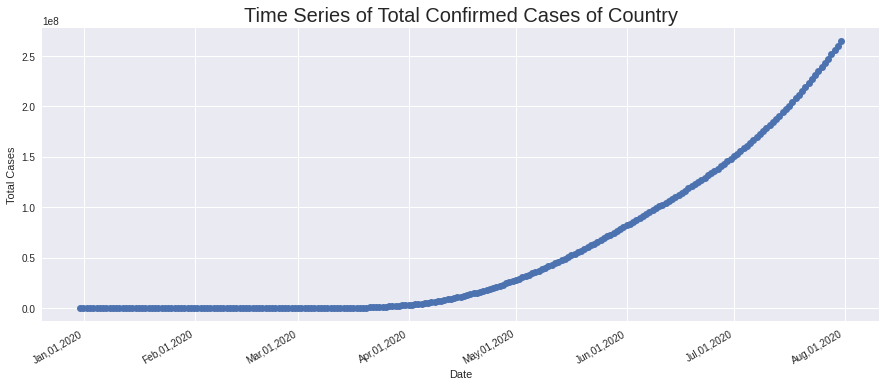

In [ ]:
# Plots accumulative confirmed cases of a country
dates = np.array(dateFormatting['new_date'])
cases = np.array(daily_total_cases)
plt.plot_date(dates, cases, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series of Total Confirmed Cases of Country', size = 20)
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.gca().xaxis.set_major_formatter(date_format)

# Plotting Features after Normalisation

In [ ]:
price_frame = pd.DataFrame(np.concatenate([price]), columns= ["Price"])
death_frame = pd.DataFrame(np.concatenate([daily_total_deaths]), columns= ["Total_Deaths_US"])
cases_frame = pd.DataFrame(np.concatenate([daily_total_cases]), columns= ["Total_Cases_US"])
diesel_frame = pd.DataFrame(np.concatenate([diesel]), columns= ["Diesel"])
brent_oil_frame = pd.DataFrame(np.concatenate([brent_oil]), columns= ["Brent_Oil"])



In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
normalisation_us_deaths = scaler.fit_transform(death_frame).reshape(-1,1)
normalisation_price = scaler.fit_transform(price_frame).reshape(-1,1)
normalisation_us_cases = scaler.fit_transform(cases_frame).reshape(-1,1)
normalisation_diesel_price = scaler.fit_transform(diesel_frame).reshape(-1,1)
normalisation_brent_oil_price = scaler.fit_transform(brent_oil_frame).reshape(-1,1)

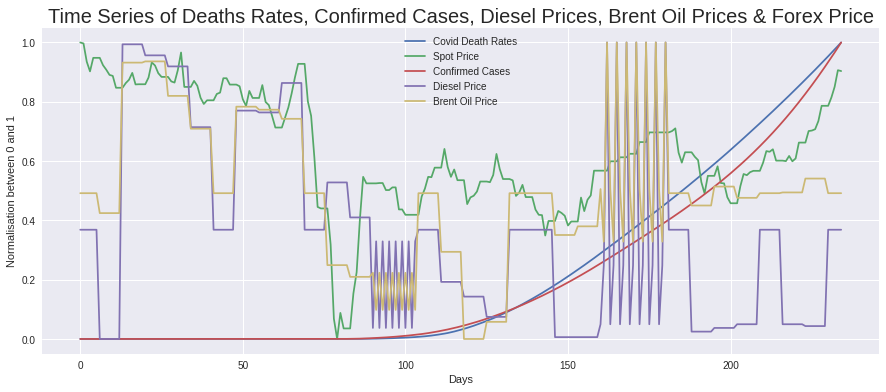

In [ ]:
plt.plot(normalisation_us_deaths,label="Covid Death Rates")
plt.plot(normalisation_price, label="Spot Price")
plt.plot(normalisation_us_cases, label="Confirmed Cases")
plt.plot(normalisation_diesel_price, label="Diesel Price")
plt.plot(normalisation_brent_oil_price, label="Brent Oil Price")
dates = np.array(dateFormatting['new_date'])
plt.title('Time Series of Deaths Rates, Confirmed Cases, Diesel Prices, Brent Oil Prices & Forex Price', size = 20)
plt.ylabel('Normalisation between 0 and 1')
plt.xlabel('Days')
plt.legend() 
plt.show()



# Bivariate Correlation 


### Creating dataset

In [ ]:
new_dataset = np.hstack((normalisation_us_cases, normalisation_us_deaths, normalisation_diesel_price, normalisation_brent_oil_price, normalisation_price))
new_dataset = pd.DataFrame(new_dataset,columns=['total_cases', 'total_deaths', 'Diesel', 'brent_oil','Price'])
new_dataset.head()

,total_cases,total_deaths,Diesel,brent_oil,Price
0,0.0,0.0,0.368447,0.491694,1.000000
1,0.0,0.0,0.368447,0.491694,0.996618
2,0.0,0.0,0.368447,0.491694,0.935175
3,0.0,0.0,0.368447,0.491694,0.902480
4,0.0,0.0,0.368447,0.491694,0.948140


### Checking for correlations between IV(s) & DV

* Values between 0.3 and 0.7 indicate a moderate positive linear relationship via a fuzzy-firm linear rule.
* Shows a positive but weak linear relationship between two varaibles.
* We can now confirm this with the linear regression correlation test below.
* Values between 0.7 and 1.0 indicate a strong positive linear relationship via a firm linear rule.
* It seems there is a strong positive linear relationship between total_deaths and total_cases

In [ ]:
print('Viewing correlation between IV(s) & ID')
print('Cases & Price:')
print(np.corrcoef(new_dataset['total_cases'], new_dataset['Price'])) # negative correlation
print('Deaths & Price:')
print(np.corrcoef(new_dataset['total_deaths'], new_dataset['Price'])) # negative correlation
print('Diesel & Price:')
print(np.corrcoef(new_dataset['Diesel'], new_dataset['Price'])) # positive but weak linear relationship
print('Brent Oil & Price:')
print(np.corrcoef(new_dataset['brent_oil'], new_dataset['Price'])) # positive but weak linear relationship

Viewing correlation between IV(s) & ID
Cases & Price:
[[ 1.         -0.03603642]
 [-0.03603642  1.        ]]
Deaths & Price:
[[ 1.         -0.04434979]
 [-0.04434979  1.        ]]
Diesel & Price:
[[1.         0.41212114]
 [0.41212114 1.        ]]
Brent Oil & Price:
[[1.         0.59610534]
 [0.59610534 1.        ]]


### Checking for correlations between IVs themselves

In [ ]:
print('Cases & Diesel:')
print(np.corrcoef(new_dataset['total_cases'], new_dataset['Diesel'])) # negative correlation
print('Deaths & Diesel:')
print(np.corrcoef(new_dataset['total_deaths'], new_dataset['Diesel'])) # negative correlation
print('Cases & Deaths:')
print(np.corrcoef(new_dataset['total_cases'], new_dataset['total_deaths'])) # very highly correlated
print('Brent Oil & Deaths:')
print(np.corrcoef(new_dataset['brent_oil'], new_dataset['total_deaths'])) # 
print('Brent Oil & Cases:')
print(np.corrcoef(new_dataset['brent_oil'], new_dataset['total_cases'])) # 
print('Brent Oil & Diesel:')
print(np.corrcoef(new_dataset['brent_oil'], new_dataset['Diesel'])) # very highly correlated

Cases & Diesel:
[[ 1.         -0.39696727]
 [-0.39696727  1.        ]]
Deaths & Diesel:
[[ 1.         -0.39844393]
 [-0.39844393  1.        ]]
Cases & Deaths:
[[1.         0.99811277]
 [0.99811277 1.        ]]
Brent Oil & Deaths:
[[1.         0.01870024]
 [0.01870024 1.        ]]
Brent Oil & Cases:
[[1.         0.00957396]
 [0.00957396 1.        ]]
Brent Oil & Diesel:
[[1.         0.73998227]
 [0.73998227 1.        ]]


### Checking for correlations throughout all on dataset Visual Representation
* Grey = No Correlation
* Dark Red = Perfect Correlation: One increases/ decreases as the other does the same
* Dark Blue = Perfect Negative Correlation: One increases the other decreases and vice versa.



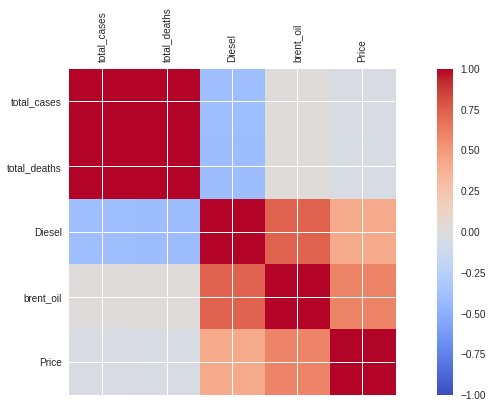

In [ ]:
corr = new_dataset.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1) 
fig.colorbar(cax)
ticks = np.arange(0,len(new_dataset.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(new_dataset.columns)
ax.set_yticklabels(new_dataset.columns)
plt.show()

### Confirming with Linear Regression Correlation Test


In [ ]:
print('Linear Regression Correlation Test IV & DV')
print(linregress(new_dataset['total_cases'], new_dataset['Price']))
print(linregress(new_dataset['total_deaths'], new_dataset['Price']))
print(linregress(new_dataset['Diesel'], new_dataset['Price']))
print(linregress(new_dataset['brent_oil'], new_dataset['Price']))
print('\nLinear Regression Correlation Test IV & DV')
print(linregress(new_dataset['total_cases'], new_dataset['total_deaths']))
print(linregress(new_dataset['total_deaths'], new_dataset['Diesel']))
print(linregress(new_dataset['Diesel'], new_dataset['total_cases']))
print(linregress(new_dataset['brent_oil'], new_dataset['Diesel']))

# Uncomment to view in decimal form
# print('\nP-Values in demical form:')
# p_val = [8.364334112081969e-29, 8.364334112081969e-29, 4.74546101987461e-11, 2.3681648096551222e-284, 1.7053545425920065e-18,1.78116028951565e-16]
# val = [print("{:.8f}".format(float(x)))for x in p_val]


Linear Regression Correlation Test IV & DV
LinregressResult(slope=-0.025414229788366254, intercept=0.6379595277197189, rvalue=-0.036036415460118536, pvalue=0.5825521148233812, stderr=0.04617163257149122)
LinregressResult(slope=-0.028818558503034268, intercept=0.6391995662789918, rvalue=-0.044349787757657105, pvalue=0.49867427506861295, stderr=0.04252802544614626)
LinregressResult(slope=0.2509671336493344, intercept=0.5402527226860068, rvalue=0.41212114493033686, pvalue=4.74546101987461e-11, stderr=0.036349119083361595)
LinregressResult(slope=0.48665488089346415, intercept=0.39343569648914123, rvalue=0.5961053374380286, pvalue=5.322160850773967e-24, stderr=0.04294226468443432)

Linear Regression Correlation Test IV & DV
LinregressResult(slope=1.0832639029338187, intercept=0.0015156509198837598, rvalue=0.9981127707444082, pvalue=2.3681648096551222e-284, stderr=0.004366153767525954)
LinregressResult(slope=-0.4251634951466894, intercept=0.46402827705231503, rvalue=-0.3984439285902275, pval

In [ ]:
X = new_dataset[['total_cases', 'total_deaths', 'Diesel', 'brent_oil']]
Y = new_dataset['Price']

### VIF


*   The Variance Inflation Factor (VIF) is a measure of colinearity among predictor variables within a multiple regression. It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone.


*   As expected, total_deaths and total_cases have a high variance inflation factor because they "explain" the similar variance within this dataset. This can also be seen above in the correlation tests where a value of [1,0.99811277] between the two variables.
*  From my research it is also mentioned that if VIF values are above 10 to remove them. We could also discard one of these variables or do further investigation.

In [ ]:
X = sm.add_constant(X)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,5.8,const
1,286.7,total_cases
2,293.7,total_deaths
3,3.7,Diesel
4,3.2,brent_oil


# Conclusion: Moving forward based on Correlations
###### After viewing the correlation between IV(s) and IDs, it was concluded that there was a negative correlation between Cases and Spot Price & Deaths and Prices meaning they move in opposite directions. However Fuel Prices had a weak-moderate positive relationship with Price indicated these two variables mildly move in the same direction. Since total_deaths/ total_cases are linked to Diesel and Diesel is linked to Spot price, we will be moving forward with these three variables, although this does leave room for further research in using brent_oil. 